In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from skimage.feature import hog
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, (128, 128))
    normalized_image = resized_image / 255.0
    return normalized_image

def load_dataset(dataset_path):
    images = []
    labels = []
    for split in ['Train', 'Validation', 'Test']:
        split_path = os.path.join(dataset_path, split, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    if image_path.endswith('.jpg') or image_path.endswith('.png'):
                        processed_image = preprocess_image(image_path)
                        images.append(processed_image)
                        labels.append(label)
    return np.array(images), np.array(labels)


In [2]:
dataset_path = '/content/drive/MyDrive/DataSets/apple'
images, labels = load_dataset(dataset_path)

def extract_features(images):
    feature_list = []
    for image in images:
        features, _ = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
        feature_list.append(features)
    return np.array(feature_list)

features = extract_features(images)


In [3]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

train_val_features = features[:len(features)*4//5]
train_val_labels = encoded_labels[:len(encoded_labels)*4//5]
test_features = features[len(features)*4//5:]
test_labels = encoded_labels[len(encoded_labels)*4//5:]

X_train, X_val, y_train, y_val = train_test_split(train_val_features, train_val_labels, test_size=0.2, random_state=42)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Validation Accuracy: 0.6290322580645161
Test Accuracy: 0.5387096774193548


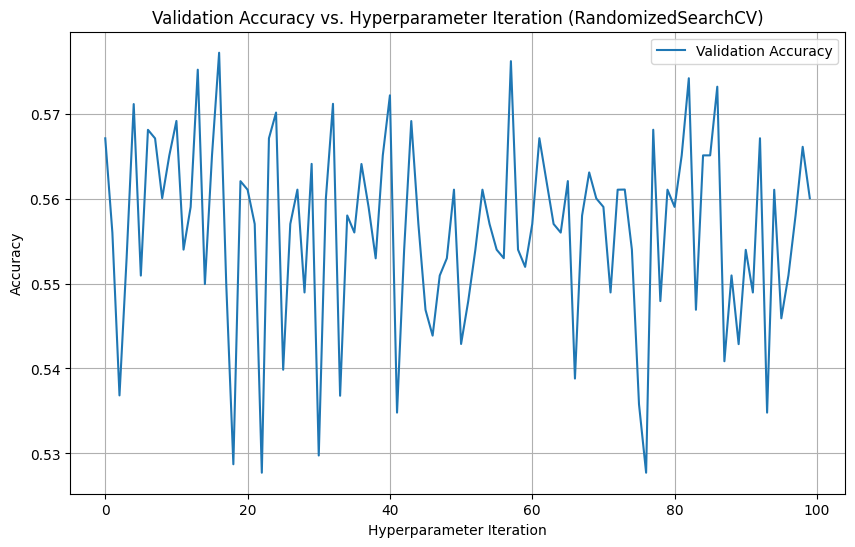

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(randint(10, 40).rvs(4)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 4),
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,  # Adjust the number of iterations based on your computational resources
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model and its accuracy
best_model = random_search.best_estimator_
val_accuracy = best_model.score(X_val, y_val)
test_accuracy = best_model.score(test_features, test_labels)

print(f'Validation Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# Plot accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(random_search.cv_results_['mean_test_score'], label='Validation Accuracy')
plt.xlabel('Hyperparameter Iteration')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Hyperparameter Iteration (RandomizedSearchCV)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
from sklearn.metrics import accuracy_score

best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f'Training Accuracy: {train_accuracy}')


Training Accuracy: 0.9989909182643795


Validation Accuracy: 0.6290322580645161
Test Accuracy: 0.5387096774193548


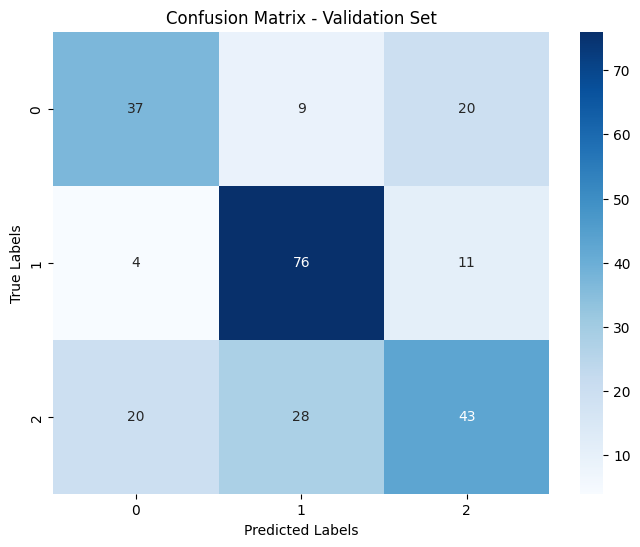

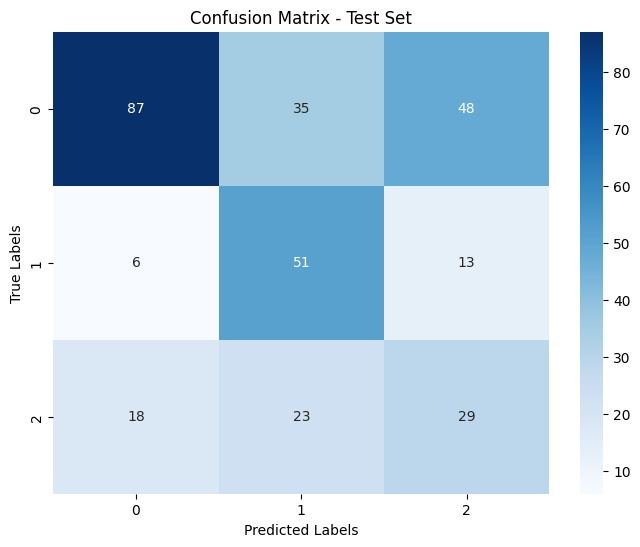

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

y_test_pred = best_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, y_test_pred)

print(f'Validation Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

val_cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

test_cm = confusion_matrix(test_labels, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()


In [6]:
def predict_image(image_path, model, label_encoder):
    processed_image = preprocess_image(image_path)
    features, _ = hog(processed_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    features = np.array([features])
    prediction = model.predict(features)
    predicted_label = label_encoder.inverse_transform(prediction)[0]
    return predicted_label

image_path = '/content/drive/MyDrive/DataSets/apple/Test/Test/Healthy/8def4d91382175c3.jpg'
predicted_label = predict_image(image_path, best_model, label_encoder)
print(f'Predicted Label: {predicted_label}')


Predicted Label: Healthy
